In [1]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==0.17.2

     |███████████████████████████████▌| 834.1 MB 1.2 MB/s eta 0:00:11tcmalloc: large alloc 1147494400 bytes == 0x564d2331c000 @  0x7f25d3b58615 0x564ce8e054cc 0x564ce8ee547a 0x564ce8e082ed 0x564ce8ef9e1d 0x564ce8e7be99 0x564ce8e769ee 0x564ce8e09bda 0x564ce8e7bd00 0x564ce8e769ee 0x564ce8e09bda 0x564ce8e78737 0x564ce8efac66 0x564ce8e77daf 0x564ce8efac66 0x564ce8e77daf 0x564ce8efac66 0x564ce8e77daf 0x564ce8e0a039 0x564ce8e4d409 0x564ce8e08c52 0x564ce8e7bc25 0x564ce8e769ee 0x564ce8e09bda 0x564ce8e78737 0x564ce8e769ee 0x564ce8e09bda 0x564ce8e77915 0x564ce8e09afa 0x564ce8e77c0d 0x564ce8e769ee
     |████████████████████████████████| 846.0 MB 22 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 82 kB 599 kB/s 
     |████████████████████████████████| 20.1 MB 27.7 MB/s 
     |████████████████████████████████| 11.6 MB 17.0 MB/s 
     |█████

# Implementation from Scratch

In [1]:
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # In this case, all elements are dropped out
    if dropout == 1:
        return np.zeros_like(X)
    # In this case, all elements are kept
    if dropout == 0:
        return X
    mask = np.random.uniform(0, 1, X.shape) > dropout
    return mask.astype(np.float32) * X / (1.0 - dropout)

In [2]:
X = np.arange(16).reshape(2, 8)
print(dropout_layer(X, 0))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1))

[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]]
[[ 0.  2.  4.  6.  8. 10. 12. 14.]
 [ 0. 18. 20.  0.  0.  0. 28.  0.]]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


# Defining Model Parameters

In [3]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = np.random.normal(scale=0.01, size=(num_inputs, num_hiddens1))
b1 = np.zeros(num_hiddens1)
W2 = np.random.normal(scale=0.01, size=(num_hiddens1, num_hiddens2))
b2 = np.zeros(num_hiddens2)
W3 = np.random.normal(scale=0.01, size=(num_hiddens2, num_outputs))
b3 = np.zeros(num_outputs)

params = [W1, b1, W2, b2, W3, b3]
for param in params:
    param.attach_grad()

# Defining the Model

In [4]:
dropout1, dropout2 = 0.2, 0.5

def net(X):
    X = X.reshape(-1, num_inputs)
    H1 = npx.relu(np.dot(X, W1) + b1)
    # Use dropout only when training the model
    if autograd.is_training():
        # Add a dropout layer after the first fully connected layer
        H1 = dropout_layer(H1, dropout1)
    H2 = npx.relu(np.dot(H1, W2) + b2)
    if autograd.is_training():
        # Add a dropout layer after the second fully connected layer
        H2 = dropout_layer(H2, dropout2)
    return np.dot(H2, W3) + b3

# [**Training and Testing**]

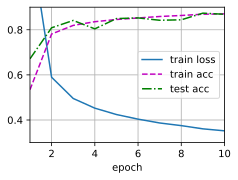

In [5]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = gluon.loss.SoftmaxCrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
              lambda batch_size: d2l.sgd(params, lr, batch_size))

# [**Concise Implementation**]

In [6]:
net = nn.Sequential()
net.add(nn.Dense(256, activation="relu"),
        # Add a dropout layer after the first fully connected layer
        nn.Dropout(dropout1),
        nn.Dense(256, activation="relu"),
        # Add a dropout layer after the second fully connected layer
        nn.Dropout(dropout2),
        nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

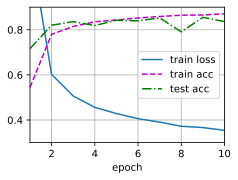

In [7]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)